# 神经网络序列生成

在这节课中，我们主要学习了用神经网络生成符号序列。在这个notebook中，我们展示了让神经网络学习形如$0^n1^n$形式的上下文无关语法。

然后在让网络生成这样的字符串，与此同时我们展示了如何使用PyTorch提供的RNN和LSTM的相关函数。在顺利完成学习任务后，我们还对RNN网络

进行了解剖，我们考察RNN是如何完成记忆的。同时，我们比较了RNN与LSTM的记忆能力。

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第VII课的配套源代码

In [2]:
# 导入程序所需要的程序包

#PyTorch用的包
import torch
import torch.nn as nn
import torch.optim
from torch.autograd import Variable

from collections import Counter #搜集器，可以让统计词频更简单

#绘图、计算用的程序包
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
#将图形直接显示出来
%matplotlib inline

## 一、字符串的生成

首先，我们生成大量的形如$0^n1^n$这样的字符串。为了让训练能够有更好的效果，我们故意生成了较多n比较小的字符串

所有字符串都是如下的形式：30001112,300112,3012,...

In [2]:
train_set = []
valid_set = []

# 生成的样本数量
samples = 2000

# 训练样本中n的最大值
sz = 10
# 定义不同n的权重，我们按照10:6:4:3:1:1...来配置字符串生成中的n=1,2,3,4,5,...
probability = 1.0 * np.array([10, 6, 4, 3, 1, 1, 1, 1, 1, 1])
# 保证n的最大值为sz
probability = probability[ : sz]
# 归一化，将权重变成概率
probability = probability / sum(probability)

# 开始生成samples这么多个样本
for m in range(samples):
    # 对于每一个生成的字符串，随机选择一个n，n被选择的权重被记录在probability中
    n = np.random.choice(range(1, sz + 1), p = probability)
    # 生成这个字符串，用list的形式完成记录
    inputs = [0] * n + [1] * n
    # 在最前面插入3表示起始字符，2插入尾端表示终止字符
    inputs.insert(0, 3)
    inputs.append(2)
    train_set.append(inputs) #将生成的字符串加入到train_set训练集中
    
# 再生成samples/10的校验样本
for m in range(samples // 10):
    n = np.random.choice(range(1, sz + 1), p = probability)
    inputs = [0] * n + [1] * n
    inputs.insert(0, 3)
    inputs.append(2)
    valid_set.append(inputs)

# 再生成若干n超大的校验样本
for m in range(2):
    n = sz + m
    inputs = [0] * n + [1] * n
    inputs.insert(0, 3)
    inputs.append(2)
    valid_set.append(inputs)
np.random.shuffle(valid_set)

## 二、用RNN来进行学习

首先，我们先让RNN来对这些字符串进行学习，然后再去实验LSTM的效果

### 1. 定义简单RNN模型

In [3]:
# 实现一个简单的RNN模型
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers = 1):
        # 定义
        super(SimpleRNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # 一个embedding层
        self.embedding = nn.Embedding(input_size, hidden_size)
        # PyTorch的RNN层，batch_first标志可以让输入的张量的第一个维度表示batch指标
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first = True)
        # 输出的全链接层
        self.fc = nn.Linear(hidden_size, output_size)
        # 最后的logsoftmax层
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, input, hidden):
        # 运算过程
        # 先进行embedding层的计算，它可以把一个数值先转化为one-hot向量，再把这个向量转化为一个hidden_size维的向量
        # input的尺寸为：batch_size, num_step, data_dim
        x = self.embedding(input)
        # 从输入到隐含层的计算
        # x的尺寸为：batch_size, num_step, hidden_size
        output, hidden = self.rnn(x, hidden)
        # 从输出output中取出最后一个时间步的数值，注意output输出包含了所有时间步的结果,
        # output输出尺寸为：batch_size, num_step, hidden_size
        output = output[:,-1,:]
        # output尺寸为：batch_size, hidden_size
        # 喂入最后一层全链接网络
        output = self.fc(output)
        # output尺寸为：batch_size, output_size
        # softmax函数
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        # 对隐含单元的初始化
        # 注意尺寸是： layer_size, batch_size, hidden_size
        return torch.zeros(self.num_layers, 1, self.hidden_size)


### 2、训练神经网络

我们进行了三重循环，Epoch作为第一重循环，然后对每个train_set中的字符串做第二重循环，最后是对每一个字符串中的每一个字符做循环

In [4]:
# 生成一个最简化的RNN，输入size为4，可能值为0,1,2,3，输出size为3，可能值为0,1,2
rnn = SimpleRNN(input_size = 4, hidden_size = 2, output_size = 3)
criterion = torch.nn.NLLLoss() #交叉熵损失函数
optimizer = torch.optim.Adam(rnn.parameters(), lr = 0.001) #Adam优化算法


#重复进行50次试验
num_epoch = 50
results = []
for epoch in range(num_epoch):
    train_loss = 0
    # 对train_set中的数据进行随机洗牌，以保证每个epoch得到的训练顺序都不一样。
    np.random.shuffle(train_set)
    # 对train_set中的数据进行循环
    for i, seq in enumerate(train_set):
        loss = 0
        hidden = rnn.initHidden()  #初始化隐含层神经元
        # 对每一个序列的所有字符进行循环
        for t in range(len(seq) - 1):
            #当前字符作为输入，下一个字符作为标签
            x = torch.tensor([seq[t]], dtype = torch.long).unsqueeze(0)
            # x尺寸：batch_size = 1, time_steps = 1, data_dimension = 1
            y = torch.tensor([seq[t + 1]], dtype = torch.long)
            # y尺寸：batch_size = 1, data_dimension = 1
            output, hidden = rnn(x, hidden) #RNN输出
            # output尺寸：batch_size, output_size = 3
            # hidden尺寸：layer_size =1, batch_size=1, hidden_size
            loss += criterion(output, y) #计算损失函数
        loss = 1.0 * loss / len(seq) #计算每字符的损失数值
        optimizer.zero_grad() # 梯度清空
        loss.backward() #反向传播，设置retain_variables
        optimizer.step() #一步梯度下降
        train_loss += loss #累积损失函数值
        # 把结果打印出来
        if i > 0 and i % 500 == 0:
            print('第{}轮, 第{}个，训练Loss:{:.2f}'.format(epoch,
                                                    i,
                                                    train_loss.data.numpy() / i
                                                   ))
            
    # 在校验集上测试

    valid_loss = 0
    errors = 0
    show_out = ''
    for i, seq in enumerate(valid_set):
        # 对每一个valid_set中的字符串做循环
        loss = 0
        outstring = ''
        targets = ''
        diff = 0
        hidden = rnn.initHidden() #初始化隐含层神经元
        for t in range(len(seq) - 1):
            # 对每一个字符做循环
            x = torch.tensor([seq[t]], dtype = torch.long).unsqueeze(0)
            # x尺寸：batch_size = 1, time_steps = 1, data_dimension = 1
            y = torch.tensor([seq[t + 1]], dtype = torch.long)
            # y尺寸：batch_size = 1, data_dimension = 1
            output, hidden = rnn(x, hidden)
            # output尺寸：batch_size, output_size = 3
            # hidden尺寸：layer_size =1, batch_size=1, hidden_size
            mm = torch.max(output, 1)[1][0] #以概率最大的元素作为输出
            outstring += str(mm.data.numpy()) #合成预测的字符串
            targets += str(y.data.numpy()[0]) #合成目标字符串
            loss += criterion(output, y) #计算损失函数
            diff += 1 - mm.eq(y) #计算模型输出字符串与目标字符串之间差异的字符数量
        loss = 1.0 * loss / len(seq)
        valid_loss += loss #累积损失函数值
        errors += diff.data.numpy()[0] #计算累积错误数
        if np.random.rand() < 0.1:
            #以0.1概率记录一个输出字符串
            show_out = outstring + '\n' + targets
    # 打印结果
    print(output[0][2].data.numpy())
    print('第{}轮, 训练Loss:{:.2f}, 校验Loss:{:.2f}, 错误率:{:.2f}'.format(epoch, 
                                                               train_loss.data.numpy() / len(train_set),
                                                               valid_loss.data.numpy()/ len(valid_set),
                                                               1.0 * errors / len(valid_set)
                                                              ))
    print(show_out)
    results.append([train_loss.data.numpy() / len(train_set), 
                    valid_loss.data.numpy() / len(train_set),
                   1.0 * errors / len(valid_set)
                   ])

第0轮, 第500个，训练Loss:0.80
第0轮, 第1000个，训练Loss:0.70
第0轮, 第1500个，训练Loss:0.64
-0.7098744
第0轮, 训练Loss:0.61, 校验Loss:0.49, 错误率:2.24
010001111
000011112
第1轮, 第500个，训练Loss:0.49
第1轮, 第1000个，训练Loss:0.49
第1轮, 第1500个，训练Loss:0.49
-0.74275374
第1轮, 训练Loss:0.49, 校验Loss:0.47, 错误率:2.24
01011
00112
第2轮, 第500个，训练Loss:0.48
第2轮, 第1000个，训练Loss:0.47
第2轮, 第1500个，训练Loss:0.47
-0.46599877
第2轮, 训练Loss:0.46, 校验Loss:0.42, 错误率:1.71
010001111
000011112
第3轮, 第500个，训练Loss:0.43
第3轮, 第1000个，训练Loss:0.42
第3轮, 第1500个，训练Loss:0.42
-0.2063644
第3轮, 训练Loss:0.40, 校验Loss:0.36, 错误率:1.58
01012
00112
第4轮, 第500个，训练Loss:0.36
第4轮, 第1000个，训练Loss:0.36
第4轮, 第1500个，训练Loss:0.35
-0.18998551
第4轮, 训练Loss:0.35, 校验Loss:0.32, 错误率:1.64
012
012
第5轮, 第500个，训练Loss:0.33
第5轮, 第1000个，训练Loss:0.32
第5轮, 第1500个，训练Loss:0.32
-0.16790652
第5轮, 训练Loss:0.32, 校验Loss:0.30, 错误率:1.47
010001212
000011112
第6轮, 第500个，训练Loss:0.31
第6轮, 第1000个，训练Loss:0.30
第6轮, 第1500个，训练Loss:0.30
-0.12757826
第6轮, 训练Loss:0.30, 校验Loss:0.29, 错误率:1.52
0100112
0001112
第7轮, 第500个，训练Loss:0.30
第7轮, 第1000

In [5]:
# 保存、提取模型（为展示用）
#torch.save(rnn,'rnn.mdl')
#rnn = torch.load('rnn.mdl')

### 3. 测试结果好坏

我们让n从0循环到20，考察模型预测的结果如何

只有当模型能够预测出最后一个1后面应该跟2（字串结束字符）才算预测正确，也就意味着模型记忆住了n这个数字。

In [6]:
for n in range(20):
    
    inputs = [0] * n + [1] * n
    inputs.insert(0, 3)
    inputs.append(2)
    outstring = ''
    targets = ''
    diff = 0
    hiddens = []
    hidden = rnn.initHidden()
    for t in range(len(inputs) - 1):
        x = torch.tensor([inputs[t]], dtype = torch.long).unsqueeze(0)
        # x尺寸：batch_size = 1, time_steps = 1, data_dimension = 1
        y = torch.tensor([inputs[t + 1]], dtype = torch.long)
        # y尺寸：batch_size = 1, data_dimension = 1
        output, hidden = rnn(x, hidden)
        # output尺寸：batch_size, output_size = 3
        # hidden尺寸：layer_size =1, batch_size=1, hidden_size
        hiddens.append(hidden.data.numpy()[0][0])
        #mm = torch.multinomial(output.view(-1).exp())
        mm = torch.max(output, 1)[1][0]
        outstring += str(mm.data.numpy())
        targets += str(y.data.numpy()[0])

        diff += 1 - mm.eq(y)
    # 打印出每一个生成的字符串和目标字符串
    print(outstring)
    print(targets)
    print('Diff:{}'.format(diff.data.numpy()[0]))

0
2
Diff:1
012
012
Diff:0
01012
00112
Diff:2
0100112
0001112
Diff:2
010001112
000011112
Diff:2
01000011112
00000111112
Diff:2
0100000111112
0000001111112
Diff:2
010000001111112
000000011111112
Diff:2
01000000011111112
00000000111111112
Diff:2
0100000000111111112
0000000001111111112
Diff:2
010000000001111111112
000000000011111111112
Diff:2
01000000000011111111112
00000000000111111111112
Diff:2
0100000000000111111111112
0000000000001111111111112
Diff:2
010000000000001111111111112
000000000000011111111111112
Diff:2
01000000000000011111111111212
00000000000000111111111111112
Diff:3
0100000000000000111111111111111
0000000000000001111111111111112
Diff:3
010000000000000001111111111111212
000000000000000011111111111111112
Diff:3
01000000000000000011111111111111111
00000000000000000111111111111111112
Diff:3
0100000000000000000111111111111111212
0000000000000000001111111111111111112
Diff:3
010000000000000000001111111111111111121
000000000000000000011111111111111111112
Diff:4


### 4. 解剖RNN

接下来，我们尝试分析一个被训练好的RNN是如何完成对下一个字符进行预测的

In [7]:
# 首先，选择特定的n，将生成的字符串喂给RNN，并让它完成预测下一个的任务，同时，我们记录下来它的隐含层神经元的每一步状态。
n = 2
inputs = [0] * n + [1] * n
inputs.insert(0, 3)
inputs.append(2)
outstring = ''
targets = ''
diff = 0
hiddens = []
hidden = rnn.initHidden()
for t in range(len(inputs) - 1):
    x = torch.tensor([inputs[t]], dtype = torch.long).unsqueeze(0)
    y = torch.tensor([inputs[t + 1]], dtype = torch.long)
    output, hidden = rnn(x, hidden)
    hiddens.append(hidden.data.numpy()[0][0]) #将每一步RNN的隐含层神经元的信息都记录下来
    #mm = torch.multinomial(output.view(-1).exp())
    mm = torch.max(output, 1)[1][0]
    outstring += str(mm.data.numpy())
    targets += str(y.data.numpy()[0])

    diff += 1 - mm.eq(y)
print(n)
print(outstring)
print(targets)
print('Diff:{}'.format(diff.data.numpy()[0]))

2
01012
00112
Diff:2


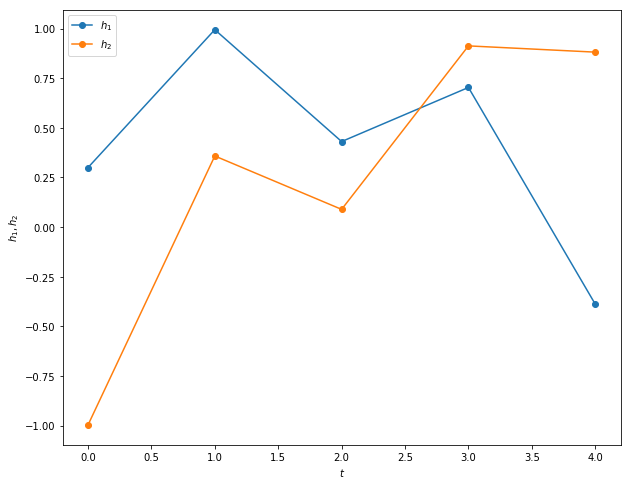

In [8]:
# 将两个隐含单元随时间步的变化情况绘制成曲线
ab =np.transpose(hiddens)

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size': 22})
# rc('text', usetex=True)
plt.figure(figsize = (10, 8))

for i in range(len(ab)):
    plt.plot(ab[i], 'o-', label = '$h_' + str(i + 1) +'$' )
plt.xlabel(r'$t$')
plt.ylabel(r'$h_1,h_2$')
plt.legend()

(-2, 2)

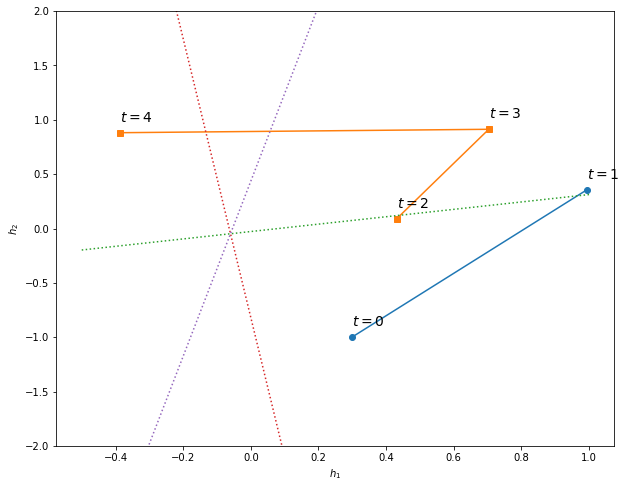

In [9]:
# 将隐含层单元的情况重新绘制到状态空间中，其中h1为横坐标，h2为纵坐标。
# 同时，我们将最后一层神经元所对应的分类线也给画出来
X_reduced = np.array(hiddens)
plt.figure(figsize = (10 , 8))
plt.plot(X_reduced[: n, 0], X_reduced[: n, 1], 'o-')
plt.plot(X_reduced[n :, 0], X_reduced[n :, 1], 's-')
xx = np.linspace(-0.5, 1, 100)

# 将神经网络的全链接层权重和bias信息提取出来
dic = dict(rnn.named_parameters()) #提取出来这个集合
weights = dic['fc.weight'].data.numpy()
bias = dic['fc.bias'].data.numpy()

# 绘制分类线
yy = - ((weights[0][0] - weights[1][0]) * xx  + (bias[0] - bias[1])) / (weights[0][1] - weights[1][1])
plt.plot(xx, yy, ':', label = '0/1')
yy = - ((weights[1][0] - weights[2][0]) * xx  + (bias[1] - bias[2])) / (weights[1][1] - weights[2][1])
plt.plot(xx, yy, ':', label = '1/2')
yy = - ((weights[0][0] - weights[2][0]) * xx  + (bias[0] - bias[2])) / (weights[0][1] - weights[2][1])
plt.plot(xx, yy, ':', label = '0/2')

zhfont1 = matplotlib.font_manager.FontProperties(size=14)
for i in range(len(hiddens)):
    plt.text(X_reduced[i, 0], X_reduced[i, 1] + 0.1, '$t=' + str(i) + '$', fontproperties = zhfont1, alpha = 1)
plt.xlabel(r'$h_1$')
plt.ylabel(r'$h_2$')
plt.ylim([-2, 2])


In [10]:
# 利用训练好的神经模型自由生成字符串
input = 3
outstring = '' + str(input)
targets = ''
diff = 0
hiddens = []
hidden = rnn.initHidden()
t = 0 #记录执行次数，最多执行1000步。
while t < 1000:
    x = torch.tensor([input], dtype = torch.long).unsqueeze(0)
    output, hidden = rnn(x, hidden)
    mm = torch.multinomial(output.view(-1).exp(), num_samples = 1 )
    outstring += str(mm.data.numpy()[0])
    input = int(mm.data.numpy()[0])
    t += 1
    if input == 2:
        break
print(t)
print(outstring)


5
300112


## 二、用LSTM来完成字符预测

接下来，我们用一个单一隐含层单元的LSTM来完成完全相同的任务

### 1. 实现一个LSTM

In [11]:
# 一个手动实现的LSTM模型，除了初始化隐含但愿部分，所有代码基本与SimpleRNN相同

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers = 1):
        super(SimpleLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # 一个embedding层
        self.embedding = nn.Embedding(input_size, hidden_size)
        # 隐含层内部的相互链接
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, input, hidden):
        
        # 先进行embedding层的计算，它可以把一个
        # x的尺寸：batch_size, len_seq, input_size
        x = self.embedding(input)
        # x的尺寸：batch_size, len_seq, hidden_size
        # 从输入到隐含层的计算
        output, hidden = self.lstm(x, hidden)
        # output的尺寸：batch_size, len_seq, hidden_size
        # hidden: (layer_size, batch_size, hidden_size),(layer_size, batch_size,hidden_size)
        output = output[:,-1,:]
        # output的尺寸：batch_size, hidden_size
        output = self.fc(output)
        # output的尺寸：batch_size, output_size
        # softmax函数
        output = self.softmax(output)
        return output, hidden
 
    def initHidden(self):
        # 对隐含单元的初始化
        # 注意尺寸是： layer_size, batch_size, hidden_size
        # 对隐单元的初始化
        # 对引单元输出的初始化，全0.
        # 注意hidden和cell的维度都是layers,batch_size,hidden_size
        hidden = torch.zeros(self.num_layers, 1, self.hidden_size)
        # 对隐单元内部的状态cell的初始化，全0
        cell = torch.zeros(self.num_layers, 1, self.hidden_size)
        return (hidden, cell)



### 2. 训练SimpleLSTM

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第III课的配套源代码

In [12]:
lstm = SimpleLSTM(input_size = 4, hidden_size = 1, output_size = 3, num_layers = 1)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr = 0.001)

num_epoch = 50
results = []

# 开始训练循环
for epoch in range(num_epoch):
    train_loss = 0
    np.random.shuffle(train_set)
    # 开始所有训练数据的循环
    for i, seq in enumerate(train_set):
        loss = 0
        hidden = lstm.initHidden()
        # 开始每一个字符的循环
        for t in range(len(seq) - 1):
            x = torch.tensor([seq[t]], dtype = torch.long).unsqueeze(0)
            # x的尺寸：batch_size, len_seq, hidden_size
            y = torch.tensor([seq[t + 1]], dtype = torch.long)
            # y的尺寸：batch_size, data_dimension
            output, hidden = lstm(x, hidden)
            # output的尺寸：batch_size, data_dimension
            # hidden: (layer_size, batch_size, hidden_size),(layer_size, batch_size,hidden_size)
            loss += criterion(output, y)
        loss = 1.0 * loss / len(seq)
        optimizer.zero_grad()
        loss.backward(retain_graph = True)
        optimizer.step()
        train_loss += loss
        if i > 0 and i % 500 == 0:
            print('第{}轮, 第{}个，训练Loss:{:.2f}'.format(epoch,
                                                    i,
                                                    train_loss.data.numpy() / i
                                                   ))
            
            
    # 在校验集上跑结果
    valid_loss = 0
    errors = 0
    show_out = ''
    for i, seq in enumerate(valid_set):
        loss = 0
        outstring = ''
        targets = ''
        diff = 0
        hidden = lstm.initHidden()
        for t in range(len(seq) - 1):
            x = torch.tensor([seq[t]], dtype = torch.long).unsqueeze(0)
            # x的尺寸：batch_size, len_seq, hidden_size
            y = torch.tensor([seq[t + 1]], dtype = torch.long)
            # y的尺寸：batch_size, data_dimension
            output, hidden = lstm(x, hidden)
            # output的尺寸：batch_size, data_dimension
            # hidden: (layer_size, batch_size, hidden_size),(layer_size, batch_size,hidden_size)
            mm = torch.max(output, 1)[1][0]
            outstring += str(mm.data.numpy())
            targets += str(y.data.numpy()[0])
            loss += criterion(output, y)
            
            diff += 1 - mm.eq(y)
        loss = 1.0 * loss / len(seq)
        valid_loss += loss
        errors += diff.data.numpy()[0]
        if np.random.rand() < 0.1:
            show_out = outstring + '\n' + targets
    print(output[0][2].data.numpy())
    print('第{}轮, 训练Loss:{:.2f}, 校验Loss:{:.2f}, 错误率:{:.2f}'.format(epoch, 
                                                               train_loss.data.numpy() / len(train_set),
                                                               valid_loss.data.numpy() / len(valid_set),
                                                               1.0 * errors / len(valid_set)
                                                              ))
    print(show_out)
    results.append([train_loss.data.numpy() / len(train_set), 
                    valid_loss.data.numpy() / len(train_set),
                   1.0 * errors / len(valid_set)
                   ])

第0轮, 第500个，训练Loss:0.83
第0轮, 第1000个，训练Loss:0.78
第0轮, 第1500个，训练Loss:0.75
-1.0362766
第0轮, 训练Loss:0.72, 校验Loss:0.64, 错误率:2.00
000001111
000011112
第1轮, 第500个，训练Loss:0.63
第1轮, 第1000个，训练Loss:0.62
第1轮, 第1500个，训练Loss:0.61
-0.69438756
第1轮, 训练Loss:0.59, 校验Loss:0.54, 错误率:2.24
002
012
第2轮, 第500个，训练Loss:0.54
第2轮, 第1000个，训练Loss:0.53
第2轮, 第1500个，训练Loss:0.53
-0.68532586
第2轮, 训练Loss:0.52, 校验Loss:0.50, 错误率:2.48
012
012
第3轮, 第500个，训练Loss:0.51
第3轮, 第1000个，训练Loss:0.50
第3轮, 第1500个，训练Loss:0.50
-0.6964309
第3轮, 训练Loss:0.50, 校验Loss:0.48, 错误率:2.48
012
012
第4轮, 第500个，训练Loss:0.49
第4轮, 第1000个，训练Loss:0.49
第4轮, 第1500个，训练Loss:0.49
-0.7214217
第4轮, 训练Loss:0.49, 校验Loss:0.48, 错误率:2.00
00011
00112
第5轮, 第500个，训练Loss:0.49
第5轮, 第1000个，训练Loss:0.49
第5轮, 第1500个，训练Loss:0.49
-0.6933396
第5轮, 训练Loss:0.48, 校验Loss:0.47, 错误率:2.48
012
012
第6轮, 第500个，训练Loss:0.48
第6轮, 第1000个，训练Loss:0.48
第6轮, 第1500个，训练Loss:0.48
-0.66248345
第6轮, 训练Loss:0.48, 校验Loss:0.47, 错误率:2.48
010000000002111111111
000000000011111111112
第7轮, 第500个，训练Loss:0.48
第7轮, 第1000个，

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第III课的配套源代码

In [30]:
# 保存、提取模型（为展示用）
#torch.save(lstm,'lstm.mdl')
#lstm = torch.load('lstm.mdl')

In [32]:
# 让n取0到50，看SimpleLSTM是否能够成功预测下一个字符
for n in range(50):
    
    inputs = [0] * n + [1] * n
    inputs.insert(0, 3)
    inputs.append(2)
    outstring = ''
    targets = ''
    diff = 0
    hiddens = []
    hidden = lstm.initHidden()
    for t in range(len(inputs) - 1):
        x = torch.tensor([inputs[t]], dtype = torch.long).unsqueeze(0)
        y = torch.tensor([inputs[t + 1]], dtype = torch.long)
        output, hidden = lstm(x, hidden)
        
        mm = torch.max(output, 1)[1][0]
        outstring += str(mm.data.numpy())
        targets += str(y.data.numpy()[0])

        diff += 1 - mm.eq(y)
    print(n)
    print(outstring)
    print(targets)
    print('Diff:{}'.format(diff.data.numpy()[0]))

0
0
2
Diff:1
1
002
012
Diff:1
2
00112
00112
Diff:0
3
0011112
0001112
Diff:1
4
001111112
000011112
Diff:2
5
00111111112
00000111112
Diff:3
6
0011111111112
0000001111112
Diff:4
7
001111111111102
000000011111112
Diff:6
8
00111111111111102
00000000111111112
Diff:7
9
0011111111111111102
0000000001111111112
Diff:8
10
001111111111111111102
000000000011111111112
Diff:9
11
00111111111111111111102
00000000000111111111112
Diff:10
12
0011111111111111111111102
0000000000001111111111112
Diff:11
13
001111111111111111111111102
000000000000011111111111112
Diff:12
14
00111111111111111111111111102
00000000000000111111111111112
Diff:13
15
0011111111111111111111111111122
0000000000000001111111111111112
Diff:14
16
001111111111111111111111111111020
000000000000000011111111111111112
Diff:17
17
00111111111111111111111111111111020
00000000000000000111111111111111112
Diff:18
18
0011111111111111111111111111111111020
0000000000000000001111111111111111112
Diff:19
19
001111111111111111111111111111111111020
000000000

In [13]:
def calculate(lstm, input, hidden):
        
    # 该函数的作用是计算出在给定的输入input下，所有门的打开关闭情况、最后的分类结果
    x = lstm.embedding(input)
    output, hidden = lstm.lstm(x, hidden)
    output = output[:,-1,:]

    output = lstm.fc(output)
    # softmax函数
    output = lstm.softmax(output)
    dic = dict(lstm.lstm.named_parameters())
    
    #提取更个中间层的权重
    weight_ih = dic['weight_ih_l0']
    weight_hh = dic['weight_hh_l0']
    bias_ih = dic['bias_ih_l0']
    bias_hh = dic['bias_hh_l0']
    #gt为一个中间变量
    all_gates = weight_ih.mm(x[0])
    gt = torch.tanh(all_gates[2])
    all_gates = torch.sigmoid(all_gates)
    all_gates[2] = gt

    return all_gates, output

### 3. 解剖LSTM

In [14]:
# 固定n＝20，计算每一步LSTM的内部状态值，并记录下来
n = 20
inputs = [0] * n + [1] * n
inputs.insert(0, 3)
inputs.append(2)
outstring = ''
targets = ''
diff = 0
hiddens = []
gates = []
outputs = []
hidden = lstm.initHidden()
dicts = dict(lstm.named_parameters())
for t in range(len(inputs) - 1):
    x = torch.tensor([inputs[t]], dtype = torch.long).unsqueeze(0)
    y = torch.tensor([inputs[t + 1]], dtype = torch.long)
    gate, out = calculate(lstm, x, hidden)
    outputs.append(np.exp(out.data.numpy()[0]))
    output, hidden = lstm(x, hidden)
    gates.append(gate.data.numpy().reshape(-1))
    hiddens.append(hidden)
    mm = torch.max(output, 1)[1][0]
    outstring += str(mm.data.numpy())
    targets += str(y.data.numpy()[0])

    diff += 1 - mm.eq(y)
print(n)
print(outstring)
print(targets)
print('Diff:{}'.format(diff.data.numpy()[0]))


20
01000000000000000000011111111111111111111
00000000000000000000111111111111111111112
Diff:3


#### 绘制曲线

In [ ]:
# 绘制输出层随时间变化的曲线
outputs = np.array(outputs)

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size': 22})
rc('text', usetex=True)
plt.figure(figsize = (10, 8))

plt.plot(outputs, 'o-')
plt.xlabel(r'$t$')
plt.ylabel(r'$o_i$')

In [ ]:
# 绘制隐含层cell与输出的数值随时间变化的曲线
states = []
cells = []

for h in hiddens:
    states.append(h[0].data.numpy()[0][0][0])
    cells.append(h[1].data.numpy()[0][0][0])
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size': 22})
rc('text', usetex=True)
plt.figure(figsize = (10, 8))

plt.plot(states, 'o-', label = '$h$')
plt.plot(cells, 's-', label = '$c$')
plt.xlabel(r'$t$')
plt.ylabel(r'$h,c$')
plt.legend()

In [ ]:
# 绘制各个门控单元的取值状态
gates = np.array(gates)

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size': 22})
rc('text', usetex=True)
plt.figure(figsize = (10, 8))
txts = ['i','f','c','o']
for i in range(len(gates[0])):
    if i != 5:
        plt.plot(gates[:, i], 'o-', label = '$' + txts[i] + '$')
plt.xlabel(r'$t$')
plt.ylabel(r'$i,f,o$')
plt.legend()

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第III课的配套源代码